# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Ingrese su nombre y apellido

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [21]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, accuracy_score
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Subir datasets de dígitos (train)

In [22]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-28 13:37:49--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt.1’

1_digits_train.txt. 100%[===================>] 625.59K  --.-KB/s    in 0.04s   

2023-10-28 13:37:49 (16.6 MB/s) - ‘1_digits_train.txt.1’ saved [640604/640604]



In [23]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-28 13:37:49--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt.1’

1_digits_test.txt.1 100%[===================>] 183.20K  --.-KB/s    in 0.02s   

2023-10-28 13:37:49 (8.50 MB/s) - ‘1_digits_test.txt.1’ saved [187595/187595]



## Leer dataset de dígitos

In [24]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [25]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [26]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


In [27]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [28]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-28-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-28-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-28-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if colu

In [29]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Crear modelo

In [30]:
def model(capas, activation, neurons):
  if (activation.lower() != "relu" and activation.lower()!= "tanh"):
    return
  if (not (capas <=2 and capas >0)):
    print("Elige entre 1 y dos capas")
    return
  act = nn.ReLU() if activation.lower() == "relu" else nn.Tanh()
  if (capas == 2):
    model = nn.Sequential(
              nn.Linear(64, neurons),
              act,
              nn.Linear(neurons, neurons),
              act,
              nn.Linear(neurons,10)
            )
  else:
    model = nn.Sequential(
              nn.Linear(64, neurons),
              act,
              nn.Linear(neurons, 10),

    )
  return model


## Crear datasets y dataloaders para pytorch (train)

In [31]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [32]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Entrenamiento

In [33]:
import matplotlib.pyplot as plt
def plot(params):
  [time, loss_train, loss_val] = params[0], params[1], params[2]
  # Graficar loss de entrenamiento Y validación
  plt.figure(figsize = (8, 5))
  plt.title('Model loss on train & validation')
  plt.xlabel('Time')
  plt.ylabel('Loss')
  plt.plot(time, loss_train, 'b', label = 'Train')
  plt.plot(time, loss_val, 'r', label = 'Validation')
  plt.grid()
  plt.legend()

In [60]:
def train(model):
  device = torch.device('cuda')
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  # Guardar resultados del loss y epocas que duró el entrenamiento
  loss_train = []
  loss_val = []
  times = []
  epochs = []
  last = float("Inf")
  # Entrenamiento de la red por n epocas
  start = time.time()
  for epoch in range(1000):

    # Guardar loss de cada batch
    loss_train_batches = []
    loss_val_batches = []

    # Entrenamiento --------------------------------------------------------------
    model.train()
    true_labels_train = []
    predicted_labels_train = []
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)           # Predicciones
      vals, predictions = torch.max(outputs, 1)
      #Guardamos las predicciones del conjunto de entrenamiento
      true_labels_train.extend(labels.cpu().numpy())
      predicted_labels_train.extend(predictions.cpu().numpy())
      loss = criterion(outputs, labels) # Loss de entrenamiento
      loss.backward()                   # Backpropagation
      optimizer.step()

      # Guardamos la pérdida de entrenamiento en el batch actual
      loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

    # Predicción en conjunto de validación ---------------------------------------
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
      # Iteramos dataloader_val para evaluar el modelo en los datos de validación
      for i, data in enumerate(dataloader_val, 0):
        # Procesar batch actual
        inputs = data["features"].to(device) # Características
        labels = data["labels"].to(device)   # Clases

        outputs = model(inputs)              # Obtenemos predicciones
        vals, predictions = torch.max(outputs, 1)
        #Guardamos las predicciones del conjunto de validacion
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        # Guardamos la pérdida de validación en el batch actual
        loss = criterion(outputs, labels)
        loss_val_batches.append(loss.item())

    # Guardamos el Loss de validación de la época actual
    loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches

    # Guardamos la época
    epochs.append(epoch)
    end = time.time()
    times.append(end-start)
    # Imprimir la pérdida de entrenamiento/validación en la época actual
    print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
    # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
    if (loss_val[epoch] > last):
      break
    else:
      last = loss_val[epoch]

  return [times, loss_train, loss_val, true_labels, predicted_labels, true_labels_train, predicted_labels_train]

#2)

In [61]:
def metrics(y_pred, y_true):
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  accuracy = accuracy_score(y_true, y_pred, normalize = True)
  return[accuracy, precision, recall, f1]

##a)

Epoch: 0, train loss: 2.2844, val loss: 2.2133
Epoch: 1, train loss: 2.1306, val loss: 2.0670
Epoch: 2, train loss: 1.9532, val loss: 1.8813
Epoch: 3, train loss: 1.7410, val loss: 1.6490
Epoch: 4, train loss: 1.5160, val loss: 1.4288
Epoch: 5, train loss: 1.2996, val loss: 1.2079
Epoch: 6, train loss: 1.1085, val loss: 1.0393
Epoch: 7, train loss: 0.9484, val loss: 0.8758
Epoch: 8, train loss: 0.8193, val loss: 0.7726
Epoch: 9, train loss: 0.7150, val loss: 0.6827
Epoch: 10, train loss: 0.6281, val loss: 0.5973
Epoch: 11, train loss: 0.5543, val loss: 0.5365
Epoch: 12, train loss: 0.4931, val loss: 0.4733
Epoch: 13, train loss: 0.4427, val loss: 0.4409
Epoch: 14, train loss: 0.4001, val loss: 0.3880
Epoch: 15, train loss: 0.3663, val loss: 0.3619
Epoch: 16, train loss: 0.3364, val loss: 0.3330
Epoch: 17, train loss: 0.3116, val loss: 0.3215
Epoch: 18, train loss: 0.2906, val loss: 0.2930
Epoch: 19, train loss: 0.2729, val loss: 0.2736
Epoch: 20, train loss: 0.2577, val loss: 0.2656
Ep

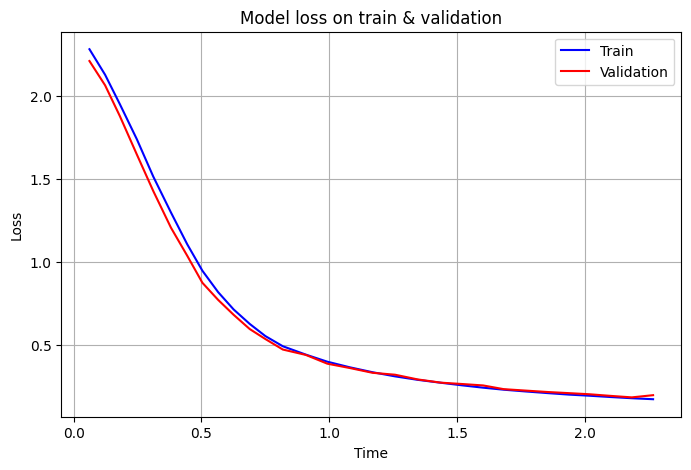

In [62]:
md = model(1, "relu", 10)
params = train(md)
plot(params)

<Axes: title={'center': 'Matriz de confusión conjunto de entrenamiento'}>

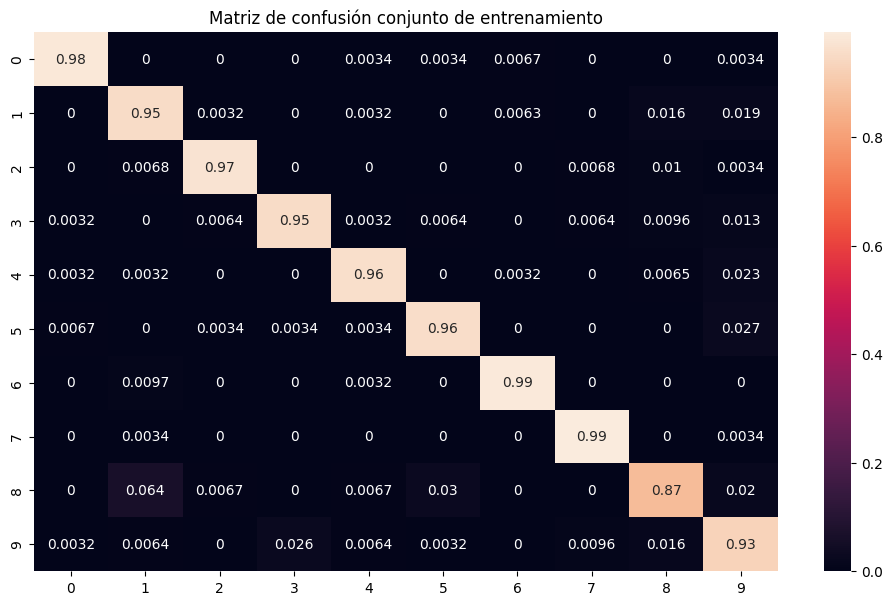

In [63]:
true_labels_train, predicted_labels_train = params[5], params[6]
confusion = confusion_matrix(true_labels_train, predicted_labels_train, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de entrenamiento")
sn.heatmap(confusion, annot=True)

<Axes: title={'center': 'Matriz de confusión conjunto de validación'}>

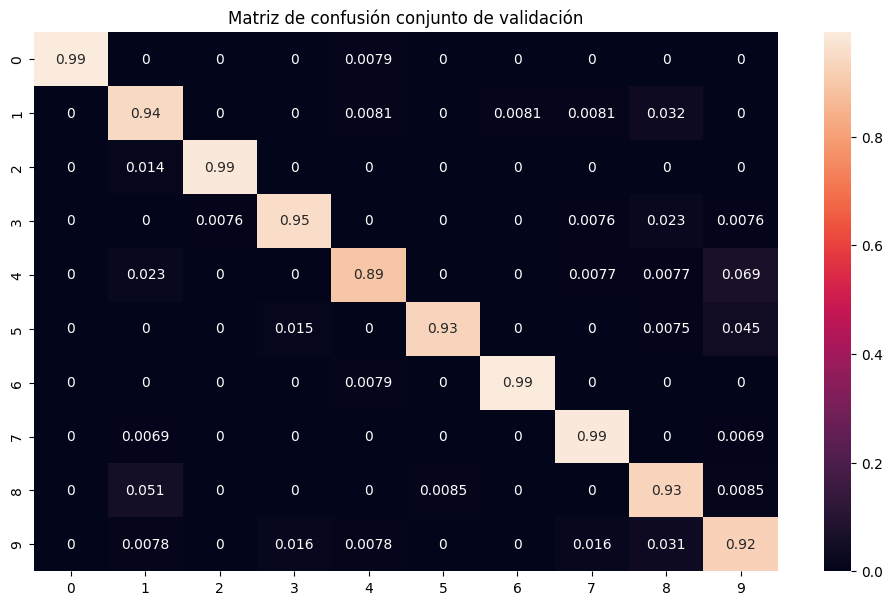

In [64]:
true_labels_val, predicted_labels_val = params[3], params[4]
confusion = confusion_matrix(true_labels_val, predicted_labels_val, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de validación")
sn.heatmap(confusion, annot=True)


In [65]:
[accuracy, precision, recall, f1] = metrics(true_labels_val, predicted_labels_val)
print("Métricas para el conjunto de validación")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de validación
Accuracy : 0.9540229885057471
Precision : 0.9543212495737378
Recall : 0.9540229885057471
f1_score : 0.9537530131903138


##b)

Epoch: 0, train loss: 2.1070, val loss: 1.8824
Epoch: 1, train loss: 1.6741, val loss: 1.4569
Epoch: 2, train loss: 1.2451, val loss: 1.0472
Epoch: 3, train loss: 0.8855, val loss: 0.7625
Epoch: 4, train loss: 0.6338, val loss: 0.5420
Epoch: 5, train loss: 0.4729, val loss: 0.4200
Epoch: 6, train loss: 0.3700, val loss: 0.3439
Epoch: 7, train loss: 0.3044, val loss: 0.2969
Epoch: 8, train loss: 0.2598, val loss: 0.2604
Epoch: 9, train loss: 0.2267, val loss: 0.2328
Epoch: 10, train loss: 0.2022, val loss: 0.2129
Epoch: 11, train loss: 0.1817, val loss: 0.1859
Epoch: 12, train loss: 0.1653, val loss: 0.1721
Epoch: 13, train loss: 0.1516, val loss: 0.1749


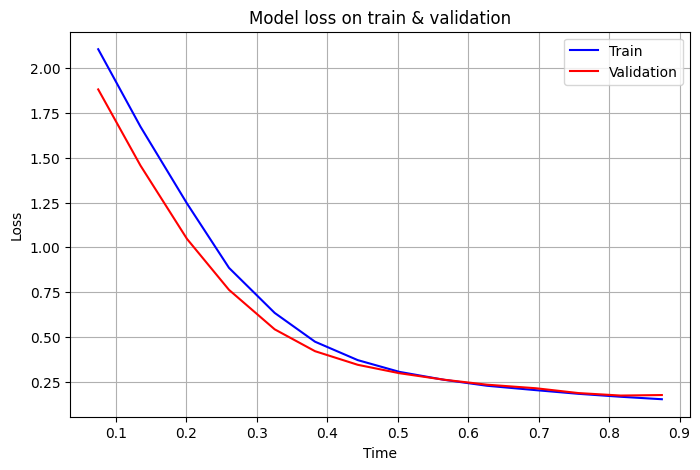

In [66]:
md = model(1, "relu", 40)
params = train(md)
plot(params)

<Axes: title={'center': 'Matriz de confusión conjunto de entrenamiento'}>

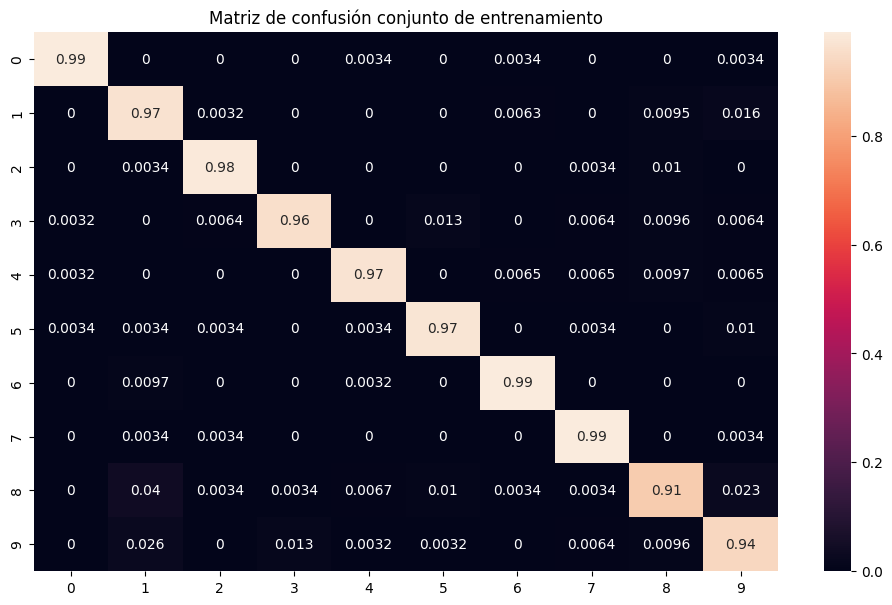

In [67]:
true_labels_train, predicted_labels_train = params[5], params[6]
confusion = confusion_matrix(true_labels_train, predicted_labels_train, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de entrenamiento")
sn.heatmap(confusion, annot=True)

<Axes: title={'center': 'Matriz de confusión conjunto de validación'}>

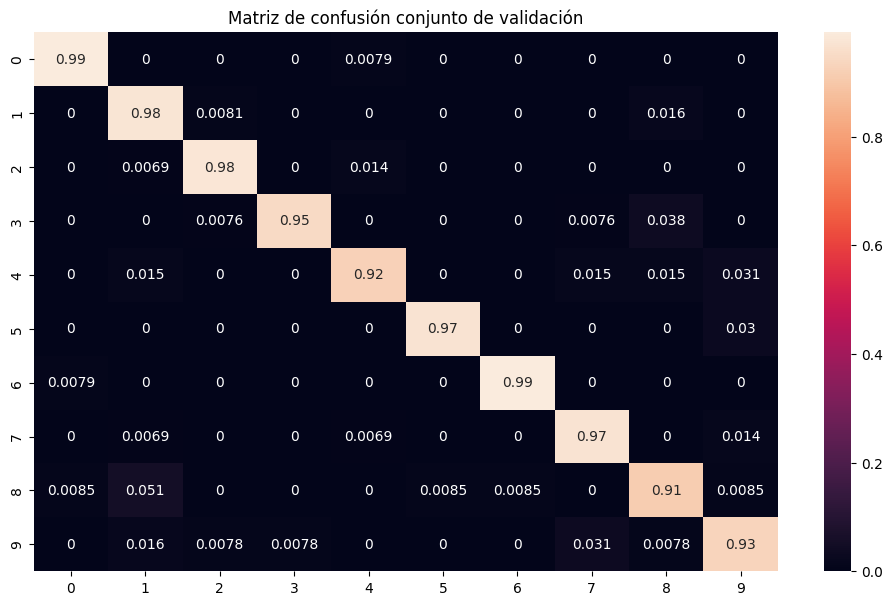

In [68]:
true_labels_val, predicted_labels_val = params[3], params[4]
confusion = confusion_matrix(true_labels_val, predicted_labels_val, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de validación")
sn.heatmap(confusion, annot=True)

In [69]:
[accuracy, precision, recall, f1] = metrics(true_labels_val, predicted_labels_val)
print("Métricas para el conjunto de validación")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de validación
Accuracy : 0.9601532567049809
Precision : 0.9604780770453525
Recall : 0.9601532567049809
f1_score : 0.9600654935370007


##c)

Epoch: 0, train loss: 2.1787, val loss: 2.0350
Epoch: 1, train loss: 1.9353, val loss: 1.8266
Epoch: 2, train loss: 1.7438, val loss: 1.6483
Epoch: 3, train loss: 1.5814, val loss: 1.5048
Epoch: 4, train loss: 1.4371, val loss: 1.3588
Epoch: 5, train loss: 1.3034, val loss: 1.2454
Epoch: 6, train loss: 1.1827, val loss: 1.1153
Epoch: 7, train loss: 1.0749, val loss: 1.0147
Epoch: 8, train loss: 0.9784, val loss: 0.9225
Epoch: 9, train loss: 0.8937, val loss: 0.8496
Epoch: 10, train loss: 0.8188, val loss: 0.7749
Epoch: 11, train loss: 0.7536, val loss: 0.7203
Epoch: 12, train loss: 0.6955, val loss: 0.6602
Epoch: 13, train loss: 0.6456, val loss: 0.6248
Epoch: 14, train loss: 0.6004, val loss: 0.5905
Epoch: 15, train loss: 0.5611, val loss: 0.5543
Epoch: 16, train loss: 0.5259, val loss: 0.5179
Epoch: 17, train loss: 0.4949, val loss: 0.4952
Epoch: 18, train loss: 0.4664, val loss: 0.4565
Epoch: 19, train loss: 0.4415, val loss: 0.4282
Epoch: 20, train loss: 0.4179, val loss: 0.4146
Ep

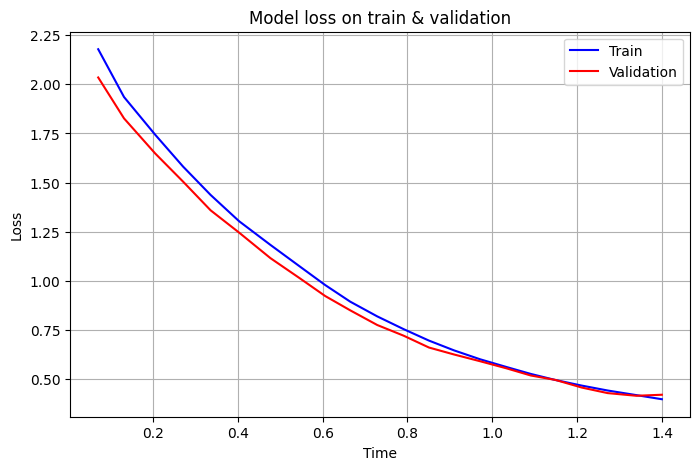

In [70]:
md = model(1, "tanh", 10)
params = train(md)
plot(params)

<Axes: title={'center': 'Matriz de confusión conjunto de entrenamiento'}>

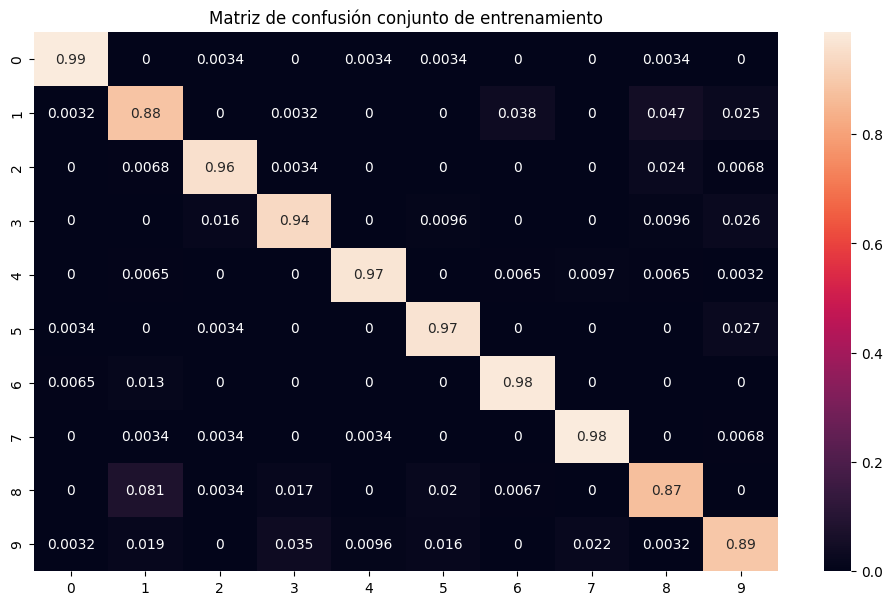

In [71]:
true_labels_train, predicted_labels_train = params[5], params[6]
confusion = confusion_matrix(true_labels_train, predicted_labels_train, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de entrenamiento")
sn.heatmap(confusion, annot=True)

<Axes: title={'center': 'Matriz de confusión conjunto de validación'}>

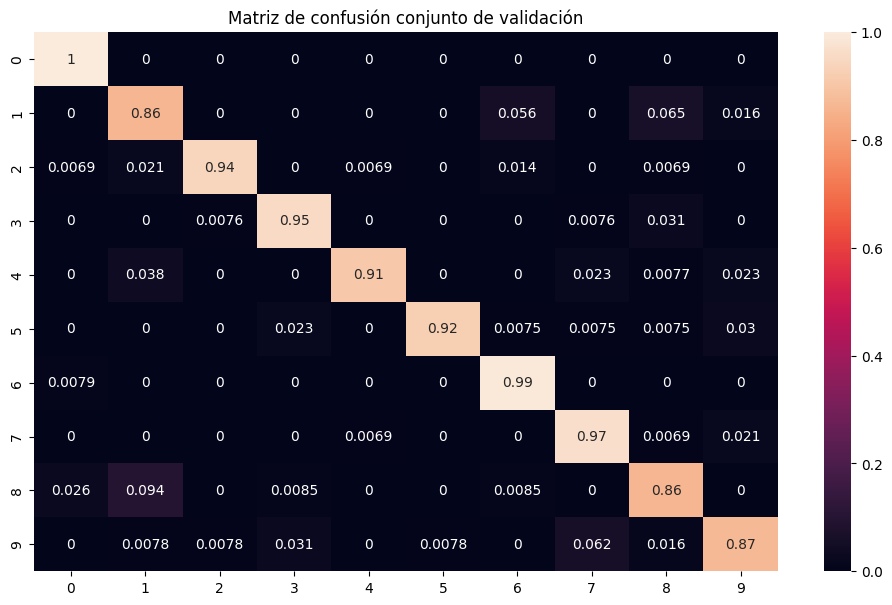

In [72]:
true_labels_val, predicted_labels_val = params[3], params[4]
confusion = confusion_matrix(true_labels_val, predicted_labels_val, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de validación")
sn.heatmap(confusion, annot=True)

In [73]:
[accuracy, precision, recall, f1] = metrics(true_labels_val, predicted_labels_val)
print("Métricas para el conjunto de validación")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de validación
Accuracy : 0.9295019157088122
Precision : 0.9306195219982781
Recall : 0.9295019157088122
f1_score : 0.9294458422872445


##d)

Epoch: 0, train loss: 1.9618, val loss: 1.6583
Epoch: 1, train loss: 1.4508, val loss: 1.2281
Epoch: 2, train loss: 1.0764, val loss: 0.9006
Epoch: 3, train loss: 0.8066, val loss: 0.6959
Epoch: 4, train loss: 0.6207, val loss: 0.5350
Epoch: 5, train loss: 0.4933, val loss: 0.4440
Epoch: 6, train loss: 0.4063, val loss: 0.3659
Epoch: 7, train loss: 0.3450, val loss: 0.3182
Epoch: 8, train loss: 0.2996, val loss: 0.2756
Epoch: 9, train loss: 0.2648, val loss: 0.2486
Epoch: 10, train loss: 0.2380, val loss: 0.2331
Epoch: 11, train loss: 0.2152, val loss: 0.2156
Epoch: 12, train loss: 0.1974, val loss: 0.2157


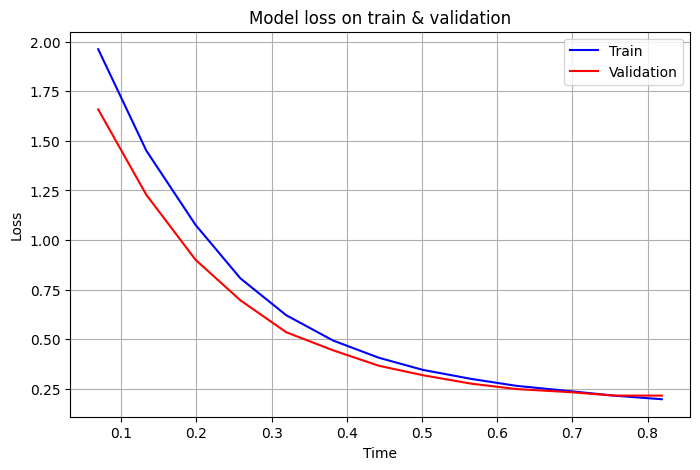

In [74]:
md = model(1, "tanh", 40)
params = train(md)
plot(params)

<Axes: title={'center': 'Matriz de confusión conjunto de entrenamiento'}>

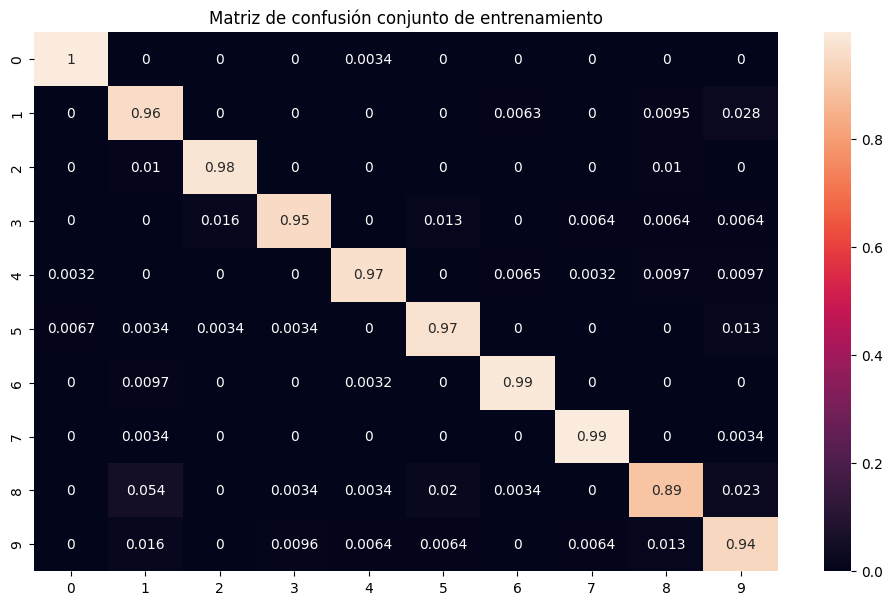

In [75]:
true_labels_train, predicted_labels_train = params[5], params[6]
confusion = confusion_matrix(true_labels_train, predicted_labels_train, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de entrenamiento")
sn.heatmap(confusion, annot=True)

<Axes: title={'center': 'Matriz de confusión conjunto de validación'}>

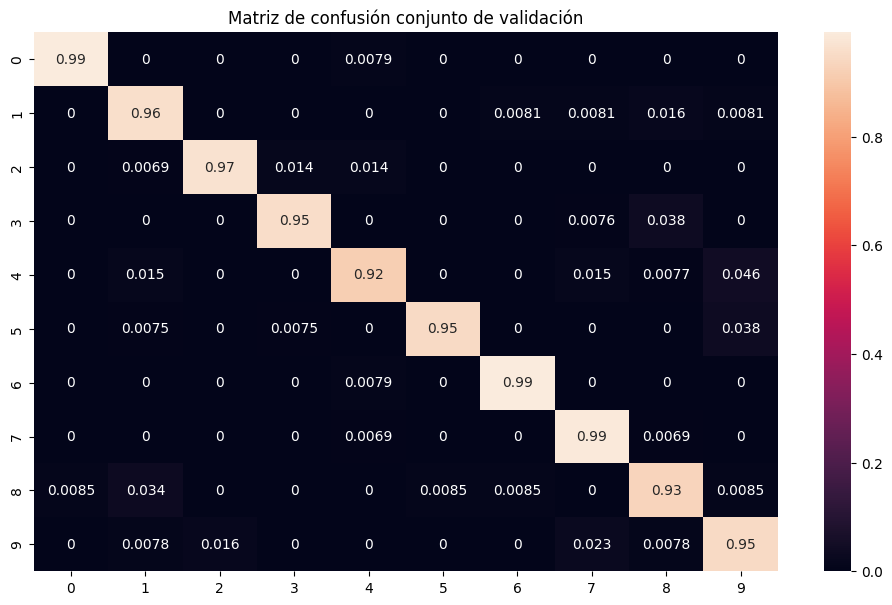

In [76]:
true_labels_val, predicted_labels_val = params[3], params[4]
confusion = confusion_matrix(true_labels_val, predicted_labels_val, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de validación")
sn.heatmap(confusion, annot=True)

In [77]:
[accuracy, precision, recall, f1] = metrics(true_labels_val, predicted_labels_val)
print("Métricas para el conjunto de validación")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de validación
Accuracy : 0.9593869731800766
Precision : 0.9596659373342018
Recall : 0.9593869731800766
f1_score : 0.9592895586514896


##e)

Epoch: 0, train loss: 2.2896, val loss: 2.2371
Epoch: 1, train loss: 2.1911, val loss: 2.1247
Epoch: 2, train loss: 2.0520, val loss: 1.9740
Epoch: 3, train loss: 1.8872, val loss: 1.8064
Epoch: 4, train loss: 1.7019, val loss: 1.6005
Epoch: 5, train loss: 1.5046, val loss: 1.3977
Epoch: 6, train loss: 1.3235, val loss: 1.2523
Epoch: 7, train loss: 1.1596, val loss: 1.0866
Epoch: 8, train loss: 1.0065, val loss: 0.9213
Epoch: 9, train loss: 0.8591, val loss: 0.7780
Epoch: 10, train loss: 0.7224, val loss: 0.6475
Epoch: 11, train loss: 0.6077, val loss: 0.5308
Epoch: 12, train loss: 0.5179, val loss: 0.4800
Epoch: 13, train loss: 0.4514, val loss: 0.4148
Epoch: 14, train loss: 0.3984, val loss: 0.3778
Epoch: 15, train loss: 0.3567, val loss: 0.3503
Epoch: 16, train loss: 0.3248, val loss: 0.3203
Epoch: 17, train loss: 0.2992, val loss: 0.3027
Epoch: 18, train loss: 0.2765, val loss: 0.2729
Epoch: 19, train loss: 0.2574, val loss: 0.2548
Epoch: 20, train loss: 0.2407, val loss: 0.2388
Ep

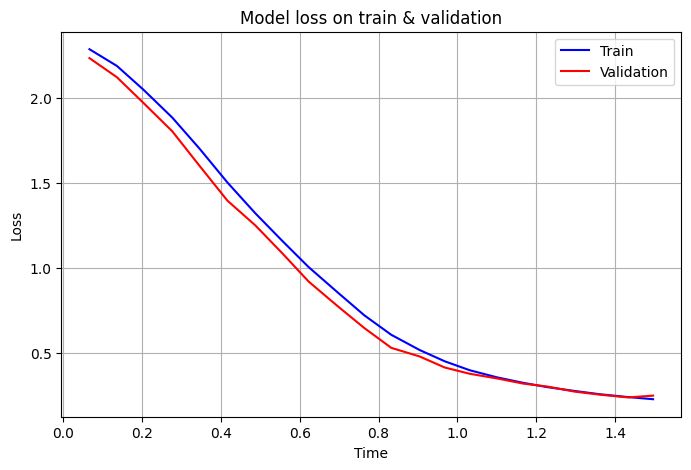

In [78]:
md = model(2, "relu", 10)
params = train(md)
plot(params)

<Axes: title={'center': 'Matriz de confusión conjunto de entrenamiento'}>

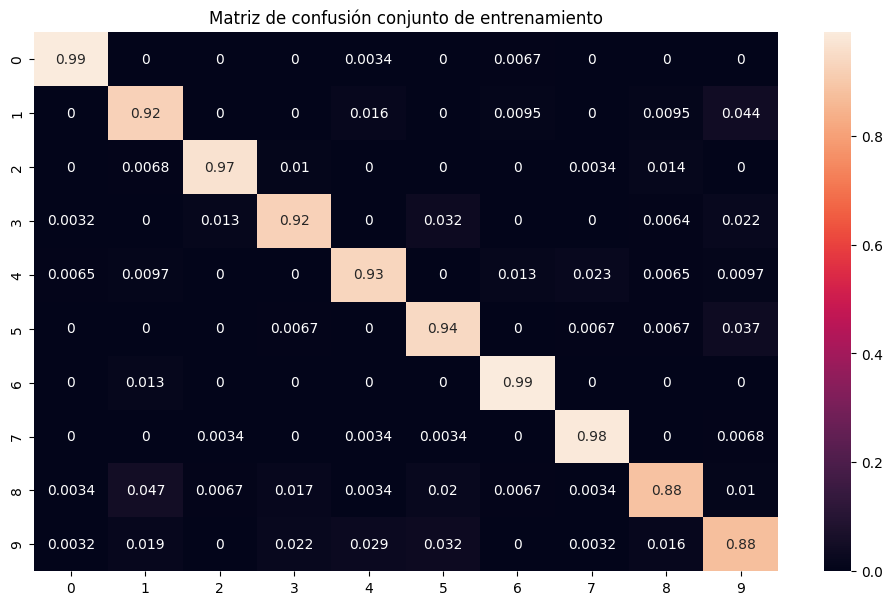

In [79]:
true_labels_train, predicted_labels_train = params[5], params[6]
confusion = confusion_matrix(true_labels_train, predicted_labels_train, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de entrenamiento")
sn.heatmap(confusion, annot=True)

<Axes: title={'center': 'Matriz de confusión conjunto de validación'}>

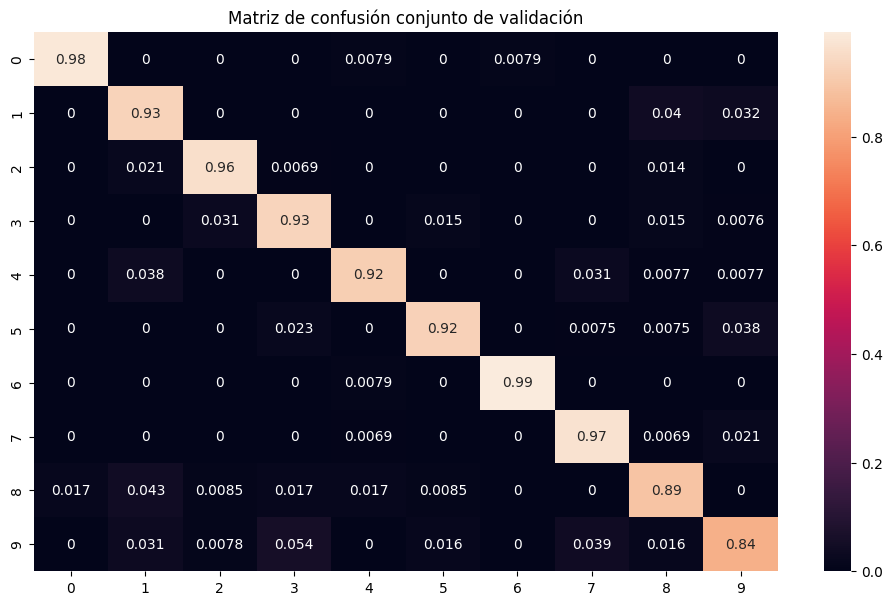

In [80]:
true_labels_val, predicted_labels_val = params[3], params[4]
confusion = confusion_matrix(true_labels_val, predicted_labels_val, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de validación")
sn.heatmap(confusion, annot=True)

In [81]:
[accuracy, precision, recall, f1] = metrics(true_labels_val, predicted_labels_val)
print("Métricas para el conjunto de validación")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de validación
Accuracy : 0.9333333333333333
Precision : 0.9340099544039996
Recall : 0.9333333333333333
f1_score : 0.9333820733005129


##f)

Epoch: 0, train loss: 2.2306, val loss: 2.1049
Epoch: 1, train loss: 1.9056, val loss: 1.6278
Epoch: 2, train loss: 1.2955, val loss: 0.9371
Epoch: 3, train loss: 0.7042, val loss: 0.5076
Epoch: 4, train loss: 0.3957, val loss: 0.3151
Epoch: 5, train loss: 0.2653, val loss: 0.2292
Epoch: 6, train loss: 0.2058, val loss: 0.1772
Epoch: 7, train loss: 0.1718, val loss: 0.1513
Epoch: 8, train loss: 0.1475, val loss: 0.1398
Epoch: 9, train loss: 0.1284, val loss: 0.1503


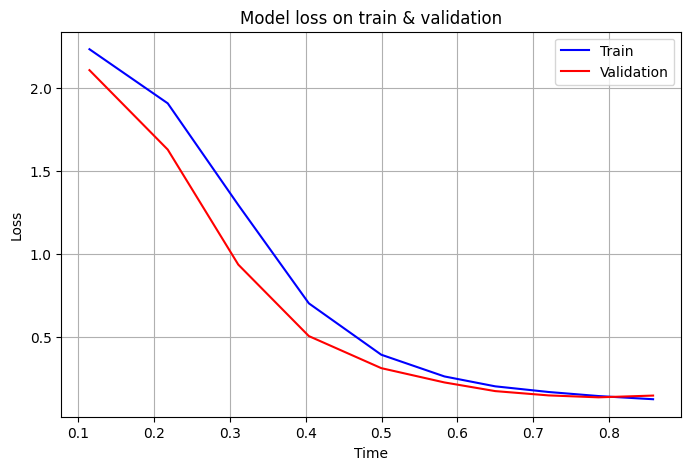

In [82]:
md = model(2, "relu", 40)
params = train(md)
plot(params)

<Axes: title={'center': 'Matriz de confusión conjunto de entrenamiento'}>

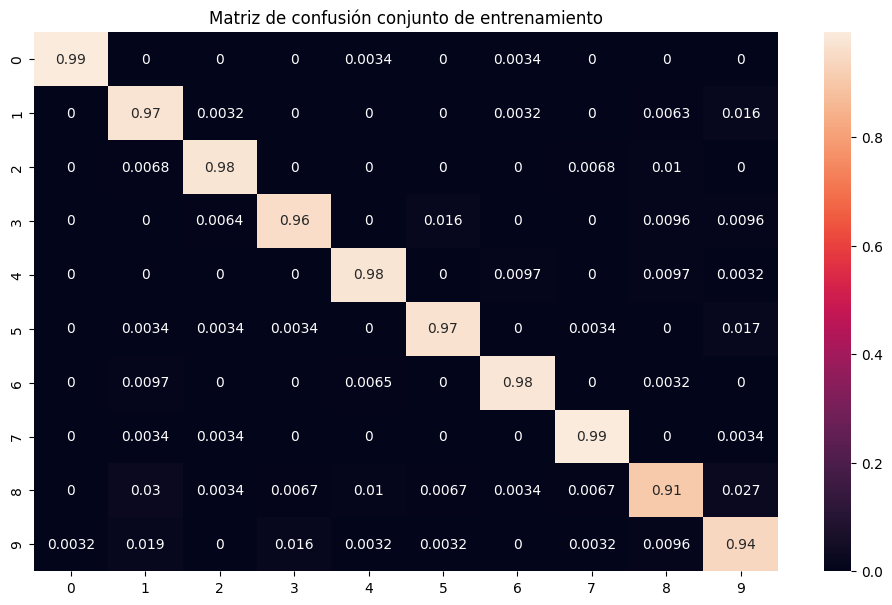

In [83]:
true_labels_train, predicted_labels_train = params[5], params[6]
confusion = confusion_matrix(true_labels_train, predicted_labels_train, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de entrenamiento")
sn.heatmap(confusion, annot=True)

<Axes: title={'center': 'Matriz de confusión conjunto de validación'}>

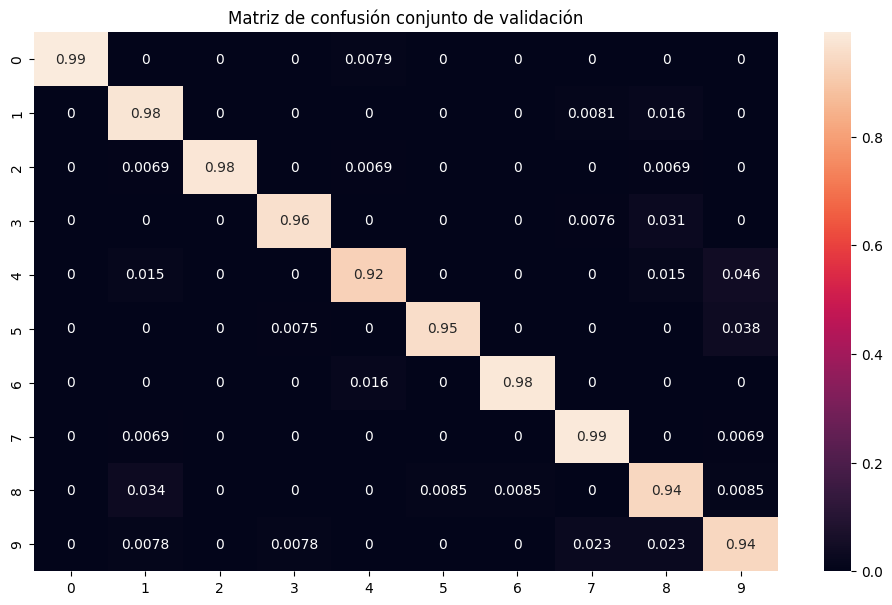

In [84]:
true_labels_val, predicted_labels_val = params[3], params[4]
confusion = confusion_matrix(true_labels_val, predicted_labels_val, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de validación")
sn.heatmap(confusion, annot=True)

In [85]:
[accuracy, precision, recall, f1] = metrics(true_labels_val, predicted_labels_val)
print("Métricas para el conjunto de validación")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de validación
Accuracy : 0.963984674329502
Precision : 0.9640550210300487
Recall : 0.963984674329502
f1_score : 0.9637705036276905


#3)

In [88]:
def train_best(model):
  device = torch.device('cuda')
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  # Guardar resultados del loss y epocas que duró el entrenamiento
  loss_train = []
  loss_val = []
  times = []
  epochs = []
  last = float("Inf")
  # Entrenamiento de la red por n epocas
  start = time.time()
  for epoch in range(1000):

    # Guardar loss de cada batch
    loss_train_batches = []
    loss_val_batches = []

    # Entrenamiento --------------------------------------------------------------
    model.train()
    true_labels_train = []
    predicted_labels_train = []
    # Debemos recorrer cada batch (lote de los datos)
    for i, data in enumerate(dataloader_train, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)           # Predicciones
      vals, predictions = torch.max(outputs, 1)
      #Guardamos las predicciones del conjunto de entrenamiento
      true_labels_train.extend(labels.cpu().numpy())
      predicted_labels_train.extend(predictions.cpu().numpy())
      loss = criterion(outputs, labels) # Loss de entrenamiento
      loss.backward()                   # Backpropagation
      optimizer.step()

      # Guardamos la pérdida de entrenamiento en el batch actual
      loss_train_batches.append(loss.item())

    # Guardamos el loss de entrenamiento de la época actual
    loss_train.append(np.mean(loss_train_batches)) # Loss promedio de los batches

    # Predicción en conjunto de validación ---------------------------------------
    model.eval()
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
      # Iteramos dataloader_val para evaluar el modelo en los datos de validación
      for i, data in enumerate(dataloader_val, 0):
        # Procesar batch actual
        inputs = data["features"].to(device) # Características
        labels = data["labels"].to(device)   # Clases

        outputs = model(inputs)              # Obtenemos predicciones
        vals, predictions = torch.max(outputs, 1)
        #Guardamos las predicciones del conjunto de validacion
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())
        # Guardamos la pérdida de validación en el batch actual
        loss = criterion(outputs, labels)
        loss_val_batches.append(loss.item())

    # Guardamos el Loss de validación de la época actual
    loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
    model.eval()
    true_labels_test = []
    predicted_labels_test = []

    with torch.no_grad():
        for i, data in enumerate(dataloader_test, 0):
            # Procesa el lote actual
            inputs = data["features"].to(device)  # Características
            labels = data["labels"].to(device)    # Clases

            outputs = model(inputs)               # Obtiene predicciones
            vals, predictions = torch.max(outputs, 1)
            # Guarda las predicciones del conjunto de prueba
            true_labels_test.extend(labels.cpu().numpy())
            predicted_labels_test.extend(predictions.cpu().numpy())
    # Guardamos la época
    epochs.append(epoch)
    end = time.time()
    times.append(end-start)
    # Imprimir la pérdida de entrenamiento/validación en la época actual
    print(("Epoch: %d, train loss: %.4f, val loss: %.4f"  %(epoch, loss_train[epoch], loss_val[epoch])))
    # Tenemos el loss de entrenamiento y validación, ¿Como sería el early-stopping?
    if (loss_val[epoch] > last):
      break
    else:
      last = loss_val[epoch]

  return [times, loss_train, loss_val, true_labels_test, predicted_labels_test]

In [89]:
md = model(2, "relu", 40)
params = train_best(md)
[true_labels_test, predicted_labels_test] = params[3], params[4]

Epoch: 0, train loss: 2.2080, val loss: 2.0582
Epoch: 1, train loss: 1.8364, val loss: 1.5379
Epoch: 2, train loss: 1.2487, val loss: 0.9509
Epoch: 3, train loss: 0.7143, val loss: 0.5027
Epoch: 4, train loss: 0.4097, val loss: 0.3370
Epoch: 5, train loss: 0.2736, val loss: 0.2549
Epoch: 6, train loss: 0.2081, val loss: 0.2010
Epoch: 7, train loss: 0.1675, val loss: 0.1738
Epoch: 8, train loss: 0.1414, val loss: 0.1397
Epoch: 9, train loss: 0.1218, val loss: 0.1270
Epoch: 10, train loss: 0.1071, val loss: 0.1170
Epoch: 11, train loss: 0.0963, val loss: 0.1118
Epoch: 12, train loss: 0.0857, val loss: 0.1155


<Axes: title={'center': 'Matriz de confusión conjunto de testeo, 2 capas con 40 neuronas c/u y relu'}>

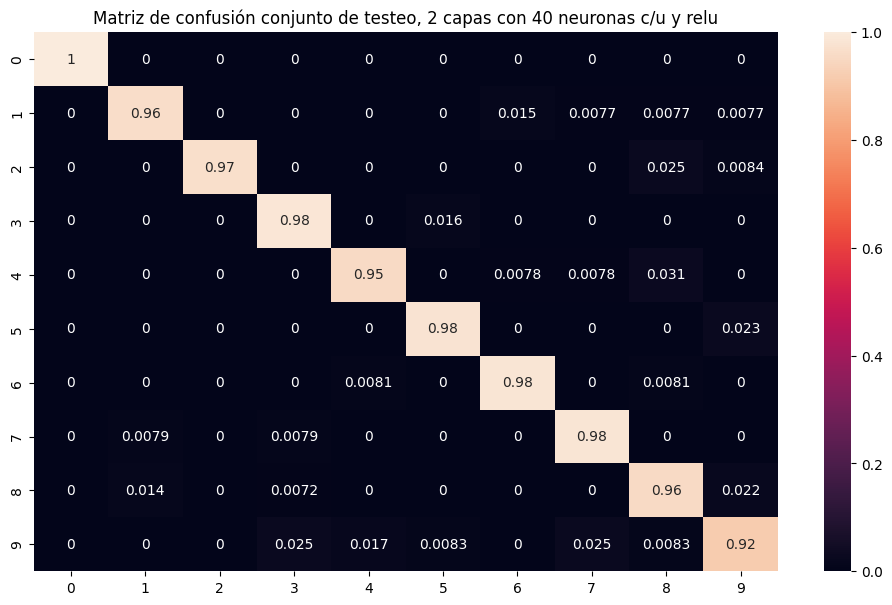

In [91]:
confusion = confusion_matrix(true_labels_test, predicted_labels_test, normalize= "true")
plt.figure(figsize = (12,7))
plt.title("Matriz de confusión conjunto de testeo, 2 capas con 40 neuronas c/u y ReLu")
sn.heatmap(confusion, annot=True)

In [92]:
[accuracy, precision, recall, f1] = metrics(true_labels_test, predicted_labels_test)
print("Métricas para el conjunto de testeo")
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_score : {f1}")

Métricas para el conjunto de testeo
Accuracy : 0.9685534591194969
Precision : 0.9687368510434099
Recall : 0.9685534591194969
f1_score : 0.9685439887478585
